In [75]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [76]:
import csv
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files

The data for this exercise is available at: https://www.kaggle.com/datamunge/sign-language-mnist/home

Sign up and download to find 2 CSV files: sign_mnist_test.csv and sign_mnist_train.csv -- You will upload both of them using this button before you can continue.


In [77]:
uploaded=files.upload()

In [78]:
def get_data(filename):
  # You will need to write code that will read the file passed
  # into this function. The first line contains the column headers
  # so you should ignore it
  # Each successive line contians 785 comma separated values between 0 and 255
  # The first value is the label
  # The rest are the pixel values for that picture
  # The function will return 2 np.array types. One with all the labels
  # One with all the images
  #
  # Tips: 
  # If you read a full line (as 'row') then row[0] has the label
  # and row[1:785] has the 784 pixel values
  # Take a look at np.array_split to turn the 784 pixels into 28x28
  # You are reading in strings, but need the values to be floats
  # Check out np.array().astype for a conversion
    with open(filename) as training_file:
        training_reader = csv.reader(training_file, delimiter=',')
        image = []
        labels = []
        line_count = 0
        for row in training_reader:
            if line_count == 0:
                line_count +=1
            else:
                labels.append(row[0])
                temp_image = row[1:785]
                image_data_as_array = np.array_split(temp_image, 28)
                image.append(image_data_as_array)
                line_count += 1
        images = np.array(image).astype('float')
        labels = np.array(labels).astype('float')
#         print(f'Processed {line_count} lines.')
      # Your code starts here
      # Your code ends here
    return images, labels


training_images, training_labels = get_data('sign_mnist_train.csv')
testing_images, testing_labels = get_data('sign_mnist_test.csv')

# Keep these
print(training_images.shape)
print(training_labels.shape)
print(testing_images.shape)
print(testing_labels.shape)

# Their output should be:
# (27455, 28, 28)
# (27455,)
# (7172, 28, 28)
# (7172,)

(27455, 28, 28)
(27455,)
(7172, 28, 28)
(7172,)


In [79]:
# In this section you will have to add another dimension to the data
# So, for example, if your array is (10000, 28, 28)
# You will need to make it (10000, 28, 28, 1)
# Hint: np.expand_dims

training_images = np.expand_dims(training_images, axis = 3)
testing_images = np.expand_dims(testing_images, axis = 3)

# Create an ImageDataGenerator and do Image Augmentation
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                   height_shift_range=0.1,
                                   width_shift_range=0.1,
                                   zoom_range=0.1,
                                   shear_range=0.1,
                                   rotation_range=10,
                                   fill_mode='nearest',
                                   horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1.0/255)

train_datagenerator = train_datagen.flow(training_images,
                                         training_labels,
                                         batch_size = 32)

validation_datagenerator = validation_datagen.flow(testing_images,
                                                   testing_labels, 
                                                   batch_size=32)

# Keep These
print(training_images.shape)
print(testing_images.shape)
    
# Their output should be:
# (27455, 28, 28, 1)
# (7172, 28, 28, 1)

(27455, 28, 28, 1)
(7172, 28, 28, 1)


In [80]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True

In [82]:
# Define the model
# Use no more than 2 Conv2D and 2 MaxPooling2D
model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape = (28,28,1)),
                                    tf.keras.layers.MaxPool2D(2,2),
                                    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
                                    tf.keras.layers.MaxPool2D(2,2),
                                    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
                                    tf.keras.layers.MaxPool2D(2,2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(256, activation = 'relu'),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(128, activation = 'relu'),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(25, activation = 'softmax')])

# Compile Model. 
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience = 2, 
                                            verbose=1,factor=0.25, 
                                            min_lr=0.0001)
# Train the Model
callbacks = myCallback()
history = model.fit_generator(train_datagenerator,
                              validation_data = validation_datagenerator,
                              steps_per_epoch = len(training_labels)//32,
                              epochs = 100,
                              validation_steps = len(testing_labels)//32,
                              callbacks = [callbacks, learning_rate_reduction])


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
857/857 [==============================] - 73s 85ms/step - loss: 2.0714 - accuracy: 0.3284 - val_loss: 0.9032 - val_accuracy: 0.6848
Epoch 2/100
857/857 [==============================] - 72s 84ms/step - loss: 0.8288 - accuracy: 0.7082 - val_loss: 0.3934 - val_accuracy: 0.8675
Epoch 3/100
857/857 [==============================] - 73s 85ms/step - loss: 0.4802 - accuracy: 0.8338 - val_loss: 0.2720 - val_accuracy: 0.9029
Epoch 4/100
857/857 [==============================] - 72s 84ms/step - loss: 0.3108 - accuracy: 0.8939 - val_loss: 0.1818 - val_accuracy: 0.9351
Epoch 5/100
857/857 [==============================] - 71s 83ms/step - loss: 0.2291 - accuracy: 0.9229 - val_loss: 0.1532 - val_accuracy: 0.9434
Epoch 6/100
857/857 [==============================] - 72s 83ms/step - loss: 0.1766 - accuracy: 0.9397 - val_loss: 0.1407 - val_accuracy: 0.9551
Epoch 7/100
857/857 [==============================] - 71s 83ms/step - loss: 0.1516 - accuracy: 0.9514 - val_loss: 0.0625 - val_ac

In [83]:
model.evaluate(testing_images, testing_labels, verbose=0)
    
# The output from model.evaluate should be close to:
[6.92426086682151, 0.56609035]

model.save('sign_language_1.h5')

In [87]:
alphab = 'abcdefghijklmnopqrstuvwxyz'
mapping_letter = {}

for i,l in enumerate(alphab):
    mapping_letter[l] = i
mapping_letter = {v:k for k,v in mapping_letter.items()}

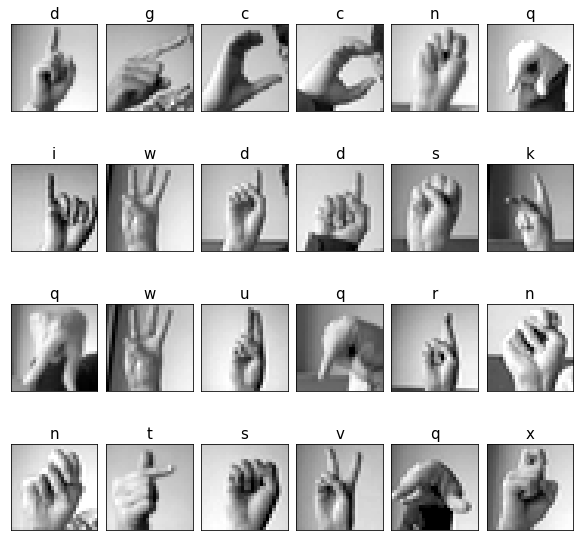

In [86]:
# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(8, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img = training_images[i].reshape(28,28)
    ax.imshow(img, cmap = 'gray')
    title = mapping_letter[training_labels[i]]
    ax.set_title(title, fontsize = 15)
plt.tight_layout(pad=0.5)
plt.show()

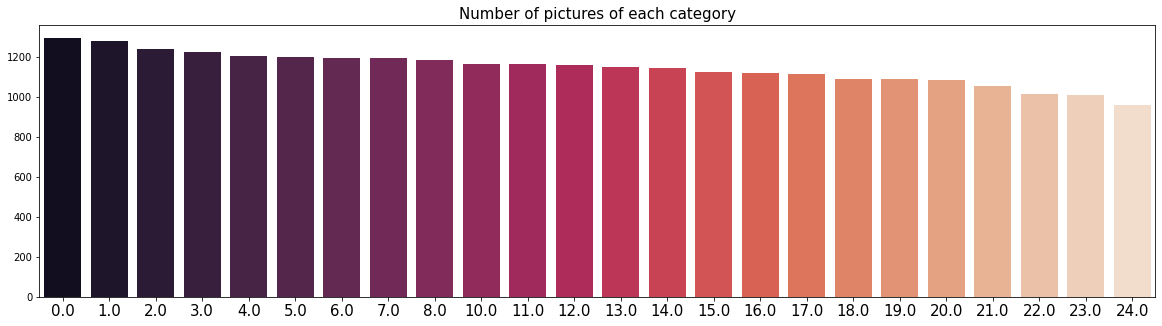

In [85]:
import pandas as pd
import seaborn as sns
# Display the number of pictures of each letter
vc = pd.Series(training_labels).value_counts()
plt.figure(figsize=(20,5))
sns.barplot(x = sorted(vc.index), y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.xticks(fontsize = 15)
plt.show()

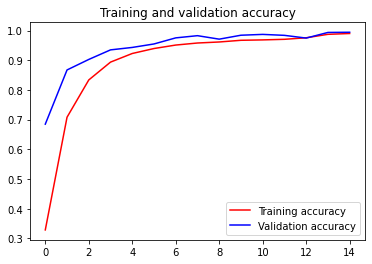

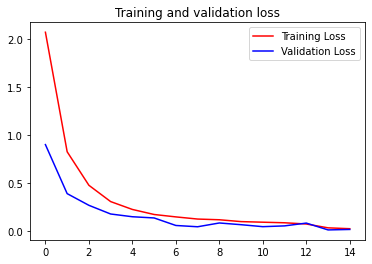

In [90]:
# Plot the chart for accuracy and loss on both training and validation

import matplotlib.pyplot as plt
fig.set_size_inches(16,9)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [91]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 11, 11, 128)       36992     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 3, 3, 256)         295168    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 1, 1, 256)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 256)              

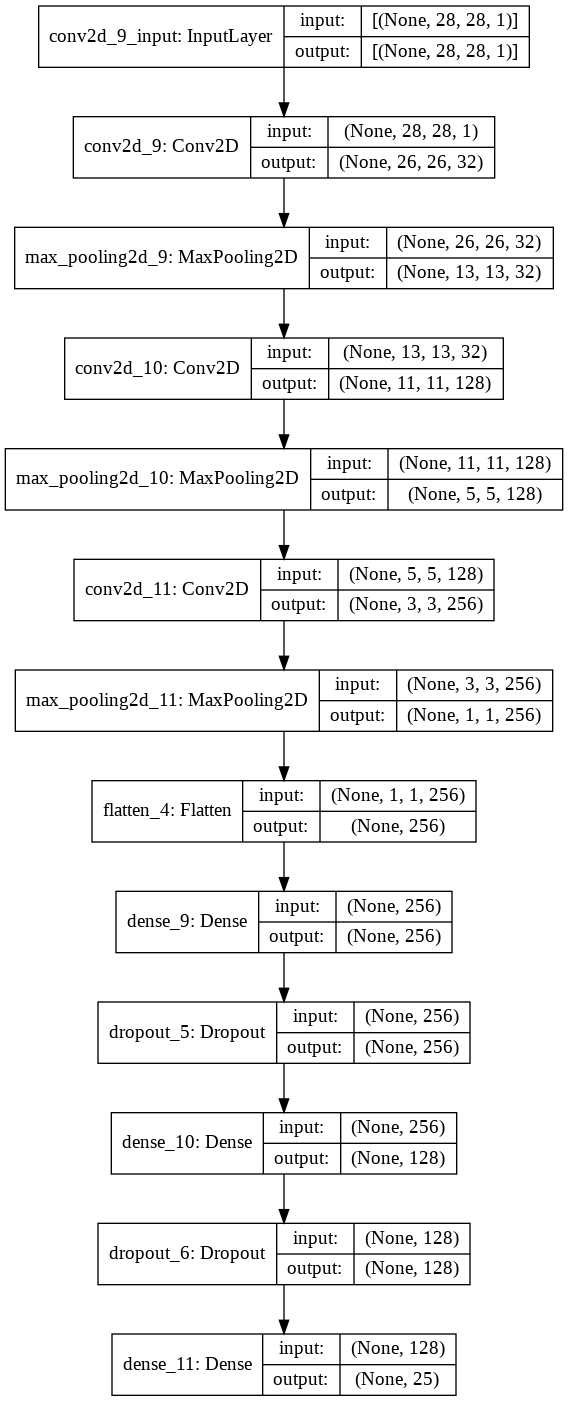

In [92]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96)

In [93]:
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
# Predict the label of the test_images
pred = model.predict(testing_images)
pred = np.argmax(pred,axis=1)

# Get the accuracy score
acc = accuracy_score(testing_labels,pred)

# Display the results
print(f'## {acc*100:.2f}% accuracy on the test set')

## 91.29% accuracy on the test set


In [94]:
# Map the numbers into letters
y_test_letters = [mapping_letter[x] for x in testing_labels]
pred_letters = [mapping_letter[x] for x in pred]

print(classification_report(y_test_letters, pred_letters)) 

              precision    recall  f1-score   support

           a       1.00      0.85      0.92       331
           b       1.00      0.99      1.00       432
           c       0.99      1.00      0.99       310
           d       1.00      0.55      0.71       245
           e       0.92      1.00      0.96       498
           f       0.99      1.00      1.00       247
           g       0.93      0.82      0.87       348
           h       1.00      0.88      0.94       436
           i       1.00      0.99      0.99       288
           k       0.97      0.76      0.85       331
           l       0.65      1.00      0.79       209
           m       0.98      1.00      0.99       394
           n       0.80      1.00      0.89       291
           o       0.90      0.98      0.94       246
           p       0.99      0.94      0.96       347
           q       0.69      1.00      0.81       164
           r       0.79      0.63      0.70       144
           s       0.74    

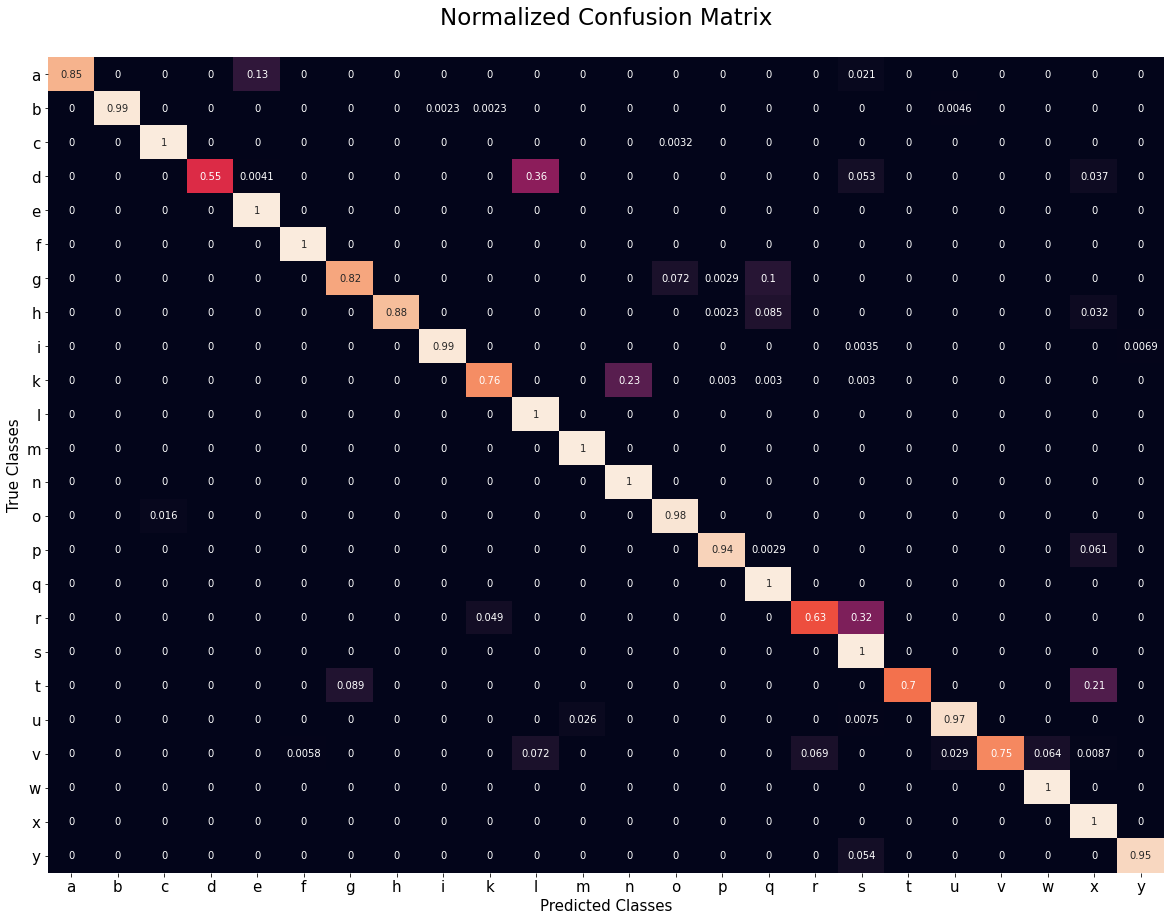

In [95]:
# Display a confusion matrix
cf_matrix = confusion_matrix(y_test_letters, pred_letters, normalize='true')
plt.figure(figsize = (20,15))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test_letters)), yticklabels = sorted(set(y_test_letters)),cbar=False)
plt.title('Normalized Confusion Matrix\n', fontsize = 23)
plt.xlabel("Predicted Classes",fontsize=15)
plt.ylabel("True Classes",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15,rotation=0)
plt.show()

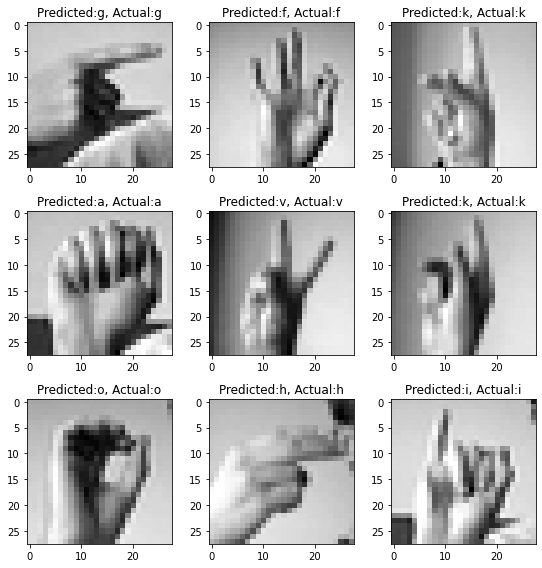

In [106]:
correct = np.nonzero(pred == testing_labels)[0]
plt.figure(figsize=(8, 8))
i = 0
for c in correct[:9]:
    plt.subplot(3,3,i+1)
    plt.imshow(testing_images[c].reshape(28,28), cmap="gray", interpolation='none')
    plt.title("Predicted:{}, Actual:{}".format(pred_letters[c], y_test_letters[c]))
    plt.tight_layout()
    i += 1

In [107]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
